# Import the Necessary Libraries

In [1]:
#IMPORT THE PANDAS AND NUMPY LIBRARIES
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.2f}'.format
import warnings
warnings.filterwarnings('ignore')

#IMPORT THE SCIKIT-LEARN LIBRARIES
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler,StandardScaler

#IMPORT THE VISUALIZATION LIBRARIES
import plotly.express as px
import kaleido
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#IMPORT THE SQALCHEMY LIBRARY's CREATE_ENGINE METHOD
import mysql.connector
from mysql.connector import Error

# Import data from MySQL DB

In [2]:
try:
    connection = mysql.connector.connect(host='scraper.cx53soegx3qk.eu-west-1.rds.amazonaws.com',
                                         database='pipedrive',
                                         user='pipedrive',
                                         password='#8LsH25%ZD', use_pure=True)
    if connection.is_connected():
        db_Info = connection.get_server_info()
        data = pd.read_sql('SELECT * FROM clustering', connection)
        print("Connected to MySQL database... MySQL Server version on ", db_Info)
except Error as e:
    print("Error while connecting to MySQL", e)
finally:
    if connection.is_connected():
        connection.close()
        print("MySQL connection is closed")

Connected to MySQL database... MySQL Server version on  8.0.35
MySQL connection is closed


# Data Preprocessing

In [3]:
#CHECK THE SHAPE OF THE DATAFRAME
data.shape

(4125075, 5)

In [4]:
data

,id_intestati,codfisc,quota,titolarita,Total_IMM
0,dcad7eb8-a5d8-4eb2-9e75-3ff0b49dca02,_SOCIETA'_COOPERATIVA_RESPONSABILITA'_LIMITATA...,1/1,Proprieta' per l'area,1
1,c557abc4-799b-4bca-a919-4637410f7884,-_DELTA_PRIMA_-_S.R.L.,,Proprieta',1
2,091aac50-96e4-4231-8d48-1e3c5b55a328,-C.L.I.COMPAGNIA_LIGURE_INVESTIMENTI,None,Proprieta',1
3,221e9517-dca2-4507-96f1-74cd44380744,-CIMEP,1/1,Proprieta' per l'area,1
4,1136dc3a-2321-4c46-ae2f-2167d2826d62,-IMPRESA_SOC.COSTR.TRONI_OMILDE_E_FIGLI-S.N.C.,None,,2
...,...,...,...,...,...
4125070,90eddf85-75fd-4255-8767-3bd3add0bd31,ZZZVTR60S58L219E,500/1000,Proprieta',3
4125071,690db6fa-15e0-4f08-9728-5d3e0d0c30b7,ZZZVTR76H25A509E,1/2,Proprieta' per 1/2,7
4125072,28f41fdb-a57a-4136-8ca2-db0b04372bb5,ZZZVTR94A02H501S,10/40,Proprieta' per 10/40,1
4125073,940a0090-038e-4a9e-90a8-3f4b41e3c151,ZZZWLY27H50L273E,1/1,Proprieta' per 1/1,1


### Removing Duplicates

In [5]:
#Drop Duplicates Rows
data.drop_duplicates(inplace=True)

### Data Imputation

In [6]:
#CHECK NULL VALUES
null_values = data.isnull().sum() / len(data) * 100
null_values[null_values > 0].sort_values(ascending=True)

titolarita   0.10
quota        6.78
dtype: float64

In [7]:
#CHECK THE DATA TYPES
data.dtypes

id_intestati    object
codfisc         object
quota           object
titolarita      object
Total_IMM        int64
dtype: object

#### Quota Column

In [8]:
#QUOTA. FILL THE NULL VALUES OF QUOTA WITH THE MODE VALUE
data['quota'].fillna(data['quota'].mode()[0], inplace=True)
data['quota'][data['quota'] == ''] = 0

In [9]:
#Split Quota column from df dataframe into two columns by "/"
data[['numerator','denominator']] = data['quota'].str.split("/",expand=True)

In [10]:
#Convert NaNs to a number (e.g., -1 or 0) or drop the rows with NaNs
data['numerator'] = data['numerator'].fillna(0) 
#Where there is numerator values. Fill the missing values in the 'denominator' column with the values in the 'numerator' column
data['denominator'][(data['denominator'].isnull())] = data['numerator'][(data['denominator'].isnull())]
#Looking for the most frequent values in the column
data.groupby('denominator')['denominator'].count().sort_values(ascending=False).head(50)
data['denominator'][data['denominator'] == ''] = data['numerator'][data['denominator'] == '']

In [11]:
#Create a column named 'division' with the ratio of 'numerator' and 'denominator'
data['%Ownership'] = data['numerator'].astype(float) / data['denominator'].astype(float) 
#Fill na values of %Ownership column with 1.00
data['%Ownership'].fillna(1.00, inplace=True)

In [12]:
data.groupby('%Ownership')['%Ownership'].count().sort_values(ascending=False)

%Ownership
1.00        2261631
0.50        1215785
0.17         113301
0.33         106946
0.25          81911
             ...   
0.05              1
0.05              1
0.05              1
0.05              1
17777.64          1
Name: %Ownership, Length: 10926, dtype: int64

#### Titolarita Column


In [13]:
data['titolarita'].fillna(data['quota'].mode()[0], inplace=True)

In [14]:
data['titolarita'] = data['titolarita'].str.replace("'", "")

In [15]:
data.groupby('titolarita')['titolarita'].count().sort_values(ascending=False)

titolarita
Proprieta                 1510067
Proprieta per 1/2          732004
Proprieta per 1/1          727074
Proprieta per 1/6           72402
Proprieta per 1/3           71889
                           ...   
Proprieta per 499/999           1
Proprieta per 499/9000          1
Proprieta per 499/8000          1
Proprieta per 499/500           1
z                               1
Name: titolarita, Length: 38836, dtype: int64

In [16]:
# DROP numerator, quota, denominator columns
data.drop(['numerator','quota','denominator','id_intestati'], axis=1, inplace=True)

### Check Outliers

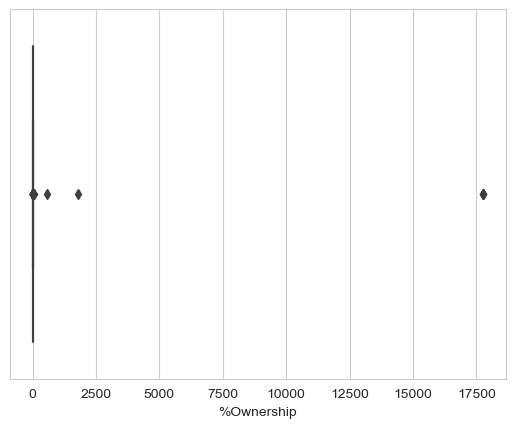

In [17]:
# Boxplot visualization
sns.boxplot(x=data['%Ownership'])
plt.show()

# IQR method
Q1 = data['%Ownership'].quantile(0.25)
Q3 = data['%Ownership'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

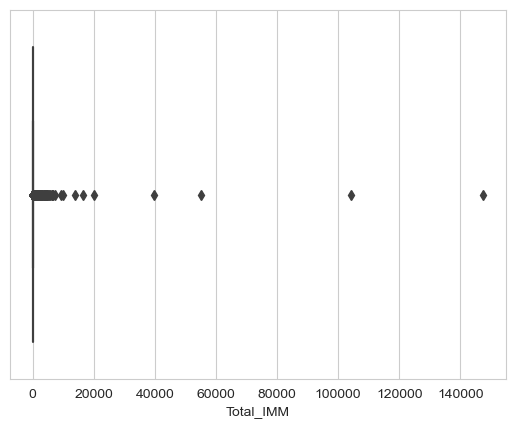

In [18]:
# Boxplot visualization
sns.boxplot(x=data['Total_IMM'])
plt.show()

# IQR method
Q1 = data['Total_IMM'].quantile(0.25)
Q3 = data['Total_IMM'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

### Descriptive Analysis

In [19]:
#CHECK THE STATISTICAL SUMMARY OF THE DATAFRAME
data.head()

,codfisc,titolarita,Total_IMM,%Ownership
0,_SOCIETA'_COOPERATIVA_RESPONSABILITA'_LIMITATA...,Proprieta per larea,1,1.00
1,-_DELTA_PRIMA_-_S.R.L.,Proprieta,1,1.00
2,-C.L.I.COMPAGNIA_LIGURE_INVESTIMENTI,Proprieta,1,1.00
3,-CIMEP,Proprieta per larea,1,1.00
4,-IMPRESA_SOC.COSTR.TRONI_OMILDE_E_FIGLI-S.N.C.,,2,1.00


### Exploratory Analysis

In [20]:
#Divide between Categorical and Numerical Features
col = list(data.columns)
#
col.remove('codfisc')
categorical_features = ['titolitaria']
numerical_features = ['Total_IMM','%Ownership']
print('Categorical Features :',*categorical_features)
print('Numerical Features :',*numerical_features)

Categorical Features : titolitaria
Numerical Features : Total_IMM %Ownership


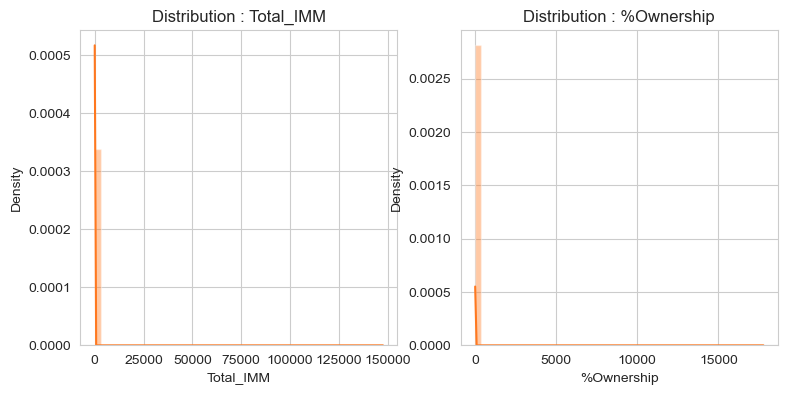

In [21]:
colors = ['#FF781F','#2D2926']
fig, ax = plt.subplots(nrows = 1,ncols = 2,figsize = (9,9))
for i in range(len(numerical_features)):
    plt.subplot(2,2,i+1)
    sns.distplot(data[numerical_features[i]],color = colors[0])
    title = 'Distribution : ' + numerical_features[i]
    plt.title(title)
plt.show()

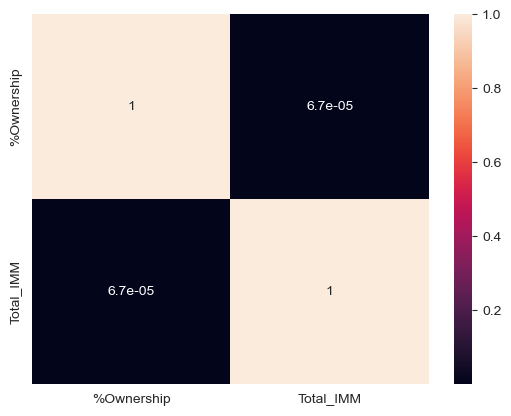

In [22]:
# Plot a correlation matrix
corr = data[['%Ownership','Total_IMM']].corr()
corr_matrix = data[['%Ownership','Total_IMM']].corr()
sns.heatmap(corr_matrix, annot=True)
plt.show()

In [23]:
data.dtypes

codfisc        object
titolarita     object
Total_IMM       int64
%Ownership    float64
dtype: object

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

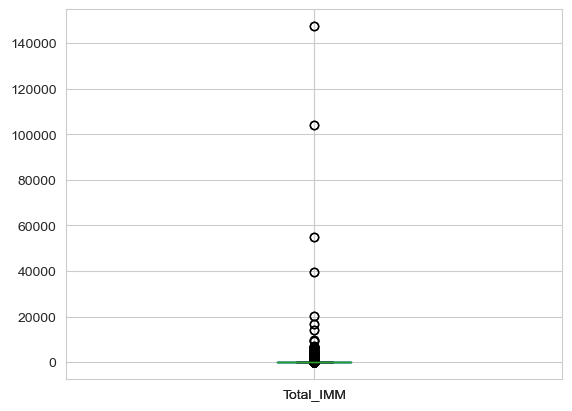

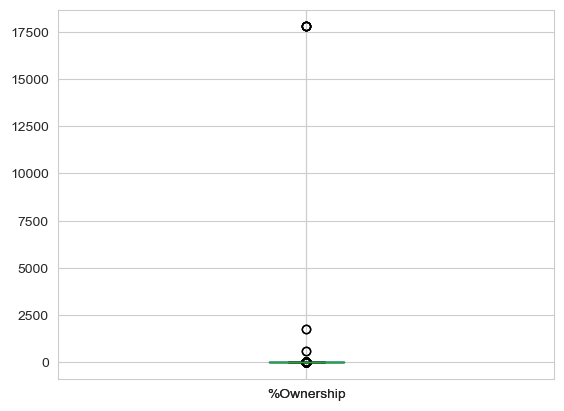

In [24]:
# Plot bar charts for numerical columns
for column in data.select_dtypes(include=[np.number]).columns:
    plt.figure()
for column in data.select_dtypes(include=[np.number]).columns:
    plt.figure()
    data.boxplot([column])

    data.boxplot([column])

# Feature Engineering

## Encoding

In [28]:
# One-hot encoding
data_encoded = pd.get_dummies(data, columns=['titolarita'], sparse=True)

In [31]:
data_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4125075 entries, 0 to 4125074
Columns: 38839 entries, codfisc to titolarita_z
dtypes: Sparse[bool, False](38836), float64(1), int64(1), object(1)
memory usage: 114.1+ MB


In [33]:
#Normalization
mms = MinMaxScaler() # Normalization

data_encoded['%Ownership'] = mms.fit_transform(data_encoded[['%Ownership']])
data_encoded['Total_imM'] = mms.fit_transform(data_encoded[['%Ownership']])
data_encoded.head()

,codfisc,Total_IMM,%Ownership,titolarita_,"titolarita_""con diritti dei singoli partecipanti ai sens",titolarita_&amp;,titolarita_&amp;1,titolarita_&amp;12,titolarita_&amp;14,titolarita_&amp;17,...,titolarita_x45,titolarita_x46,titolarita_x500/1000,titolarita_x69,titolarita_x750/1000,titolarita_xfabbricato e sottosuolo,titolarita_xui,titolarita_ypx 1/3,titolarita_z,Total_imM
0,_SOCIETA'_COOPERATIVA_RESPONSABILITA'_LIMITATA...,1,0.00,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.00
1,-_DELTA_PRIMA_-_S.R.L.,1,0.00,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.00
2,-C.L.I.COMPAGNIA_LIGURE_INVESTIMENTI,1,0.00,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.00
3,-CIMEP,1,0.00,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.00
4,-IMPRESA_SOC.COSTR.TRONI_OMILDE_E_FIGLI-S.N.C.,2,0.00,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,0.00


In [ ]:
#Drop 

## Principal Component Analysis (PCA) - Reducing Dimensionality

In [ ]:
#No need for now

# Model Training

### K-means clustering

In [34]:
#DEFINE THE NUMBER OF CLUSTERS
n_clusters = 3

In [35]:
#CREATE THE KMEANS MODEL
kmeans = KMeans(n_clusters=n_clusters, random_state=0)

In [ ]:
#FIT THE MODEL
kmeans.fit(X)

In [ ]:
#PREDICT THE CLUSTERS
data['cluster'] = kmeans.predict(X)

### DBSCAN Clustering

### Divisive hierarchical clustering

### Agglomerative hierarchical clustering

### Mean Shift Clustering

### Spectral Clustering

### Affinity Propagation

### BIRCH Clustering

# Model Evaluation

# Deployment

# Monitoring